Основные шаги:

    EDA.
    Построение модели.
    Тестирование модели.
    Улучшение модели.
    Production.

# Шаг 1. EDA.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv.zip', low_memory=False)
test = pd.read_csv('data/test.csv.zip', low_memory=False)
submission = pd.read_csv('data/sample_submission.csv.zip', low_memory=False)

In [3]:
train = train.drop_duplicates().reset_index(drop = True) # удалим дубликаты, если есть

In [4]:
def param_data(data): # посмотрим на данные
    """dataset required parameters """
    param = pd.DataFrame({
              'dtypes': data.dtypes.values,
              'nunique': data.nunique().values,
              'isna': data.isna().sum().values,
              'loc[0]': data.loc[0].values,
              }, 
             index = data.loc[0].index)
    return param

In [5]:
pd.concat([param_data(train), param_data(test)], 
          axis=1, 
          keys = [f'↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓ {train.shape}', f'↓ ТЕСТОВАЯ ВЫБОРКА ↓ {test.shape}'],  
          sort=False)

↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓ (826895, 14)                      \
                                           dtypes   nunique      isna   
overall                                   float64       5.0       0.0   
verified                                     bool       2.0       0.0   
reviewTime                                 object    4580.0       0.0   
asin                                       object   41302.0       0.0   
reviewerName                               object  101207.0     164.0   
reviewText                                 object  686739.0     274.0   
summary                                    object  411451.0     166.0   
unixReviewTime                              int64    4580.0       0.0   
vote                                       object     311.0  712944.0   
style                                      object   25892.0  398698.0   
image                                      object    6636.0  819916.0   
userid                                      int64  127448.0       0.0   
itemid                                      int64   41302.0       0.0   
rating                                    float64       2.0       0.0   
Id                                            NaN       NaN       NaN   

                                                                   \
                                                           loc[0]   
overall                                                         5   
verified                                                     True   
reviewTime                                             10 4, 2016   
asin                                                   B01CPNIEQG   
reviewerName                                              Heather   
reviewText      These are my FAVORITE spices in my collection....   
summary                           Must Add to your Spice kitchen!   
unixReviewTime                                         1475539200   
vote                                                          NaN   
style                                                         NaN   
image                                                         NaN   
userid                                                     102179   
itemid                                                      37138   
rating                                                          1   
Id                                                            NaN   

               ↓ ТЕСТОВАЯ ВЫБОРКА ↓ (285965, 11)                      \
                                          dtypes   nunique      isna   
overall                                      NaN       NaN       NaN   
verified                                    bool       2.0       0.0   
reviewTime                                object    4349.0       0.0   
asin                                      object   37876.0       0.0   
reviewerName                              object   86815.0      47.0   
reviewText                                   NaN       NaN       NaN   
summary                                      NaN       NaN       NaN   
unixReviewTime                             int64    4349.0       0.0   
vote                                      object     198.0  246503.0   
style                                     object   18904.0  138285.0   
image                                     object    2306.0  283597.0   
userid                                     int64  109357.0       0.0   
itemid                                     int64   37876.0       0.0   
rating                                       NaN       NaN       NaN   
Id                                         int64  285965.0       0.0   

                            
                    loc[0]  
overall                NaN  
verified              True  
reviewTime      10 1, 2016  
asin            B001E5E3X0  
reviewerName     Rudys Mom  
reviewText             NaN  
summary                NaN  
unixReviewTime  1475280000  
vote                   NaN  
style                  NaN  
image                  NaN

Описание датасета:

    overall - рейтинг, который поставил пользователь (значения от 1 до 5)
    verified - был ли отзыв верифицирован (значения True или False)
    reviewTime - когда был отзыв написан
    asin - предположительно, серийный номер или штрихкод
    reviewerName - имя пользователя
    reviewText - текст отзыва
    summary - сжатый отзыв
    unixReviewTime - когда был отзыв написан в формате unix
    vote - количество голосований за отзыв (значения - целые числа, представленные в виде строки)
    style - метаданные ( значения словари с описанием размера порции и аромата продукта)
    image - изображение продукта
    userid - id пользователя
    itemid - id товара
    rating - предположительно, это понравился или не понравился товар, значения (1, если overall>=4 или 0) - target???
    Id - id для предсказания


In [15]:
train.sample(5)

overall  verified   reviewTime        asin   reviewerName  \
505512      4.0      True  04 14, 2015  B000HRS7OM     PanzerPink   
46815       5.0      True   01 3, 2014  B0027Z5J6G        B. Wood   
477392      5.0      True   06 5, 2016  B004LW8AH8    Eric Hanson   
160288      1.0     False  07 23, 2016  B00CAC6XBG  Q.C. Stickler   
602385      3.0      True   05 8, 2018  B0101A2FFQ   Half a Brain   

                                               reviewText  \
505512  I tried Barry's Blend (gold) and PG Tips. York...   
46815   Nice dark roast. I would never have known it w...   
477392  Regularly ordered product. Easy product with w...   
160288  This is more "Frankenfood" from Con Agra. Made...   
602385  Cute tin. For the price, not a good value on t...   

                                                  summary  unixReviewTime  \
505512  Get the gold version, best rich black tea I ha...      1428969600   
46815                                    Love this stuff!      1388707200   
477392              Easy product with which to make vegie      1465084800   
160288  This is more frankenfood from Con Agra. Made w...      1469232000   
602385                     not a good value on the matcha      1525737600   

       vote                                              style image  userid  \
505512  NaN                                                NaN   NaN    5794   
46815   NaN          {'Size:': ' 2.2 lb', 'Flavor:': ' Decaf'}   NaN   12968   
477392  NaN  {'Size:': ' 100 Servings Tub', 'Flavor:': ' Wh...   NaN   42244   
160288  NaN                           {'Size:': ' 58.4 Ounce'}   NaN    2832   
602385  NaN                                                NaN   NaN   26874   

        itemid  rating  sample  
505512    2688     1.0       1  
46815    10264     1.0       1  
477392   13835     1.0       1  
160288   22655     0.0       1  
602385   34395     0.0       1

In [7]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

rec = test.append(train, sort=False).reset_index(drop=True) # объединяем

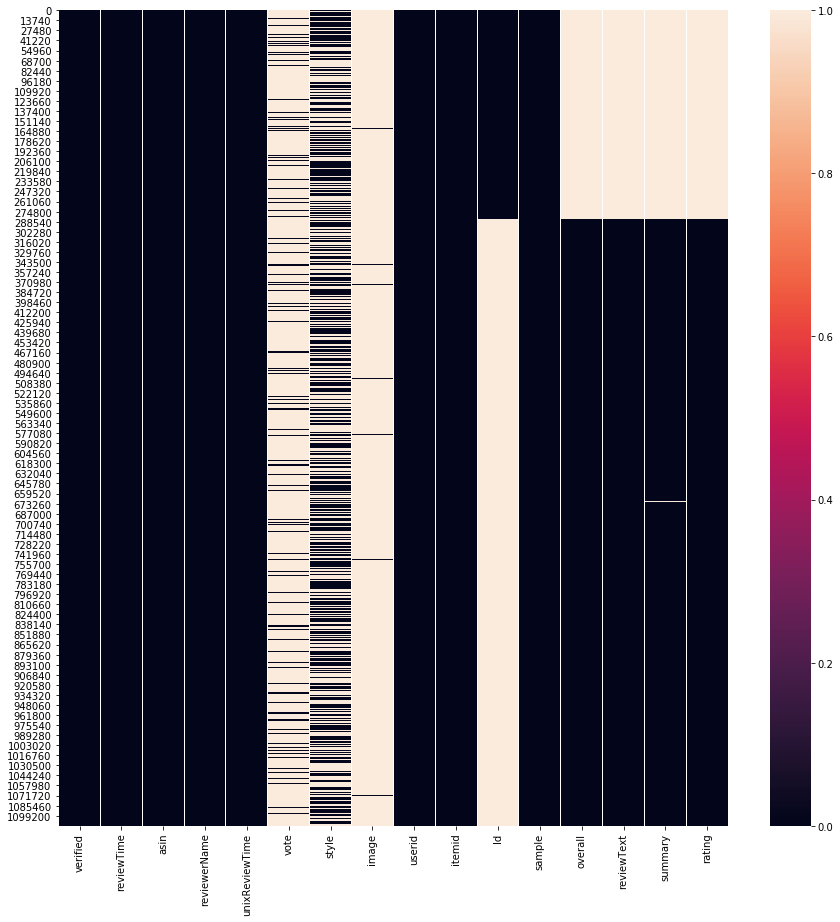

In [8]:
plt.subplots(figsize=(15, 15))
sns.heatmap(rec.isnull())

In [9]:
# Функция для подсчета пустых значений
def missing_values_table(df):
        # Количество пропущенных значений
        mis_val = df.isnull().sum()
        
        # Процент пропущенных значений
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        #Таблица с результатами
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Переименовываем колонки
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Сортируем значения по проценту
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Печать дополнительной информации
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
       
        return mis_val_table_ren_columns

In [10]:
missing_values_table(rec)

Your selected dataframe has 16 columns.
There are 9 columns that have missing values.


Missing Values  % of Total Values
image                1103513               99.2
vote                  959447               86.2
Id                    826895               74.3
style                 536983               48.3
reviewText            286239               25.7
summary               286131               25.7
overall               285965               25.7
rating                285965               25.7
reviewerName             211                0.0

Вывод:
    
    Три переменные: image, vote, style, которые присутствуют в обеих выборках, имеют большой процент пропущенных 
    значений.

In [3]:
import json
food = [json.loads(line) for line in open('data/meta_Grocery_and_Gourmet_Food.json', 'r')]

In [4]:
food

[{'category': ['Grocery & Gourmet Food',
   'Dairy, Cheese & Eggs',
   'Cheese',
   'Gouda'],
  'description': ['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS',
   'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.'],
  'title': 'Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs',
  'brand': 'Ariola Imports',
  'rank': '165,181inGroceryGourmetFood(',
  'also_view': ['B0000D9MYM',
   'B0000D9MYL',
   'B00ADHIGBA',
   'B00H9OX598',
   'B001LM42GY',
   'B001LM5TDY'],
  'main_cat': 'Grocery',
  'price': '$41.91',
  'asin': '0681727810'},
 {'category': ['Grocery & Gourmet Food',
   'Cooking & Baking',
   'Sugar Substitutes',
   'Xylitol'],
  'description': ['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd',
   'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, 

to be continued...